# Chapter4. Dynamic Programming with V value
---

### Import grid environment

In [1]:
import import_ipynb
from grid_env import GridEnv, policy_visualize, StateValueFunction_visualize

import numpy as np
import random
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

importing Jupyter notebook from GridEnv.ipynb


### Generate Random Policy $\pi(a|s)$

In [2]:
# 4 actions and 100 states -> 4x100 size
def policy_generation(env):
    policy = np.zeros([len(env.obs_space), len(env.action_space)])
    for i in range(len(env.obs_space)):
        policy[i] = [0.25]*4
            
    return policy

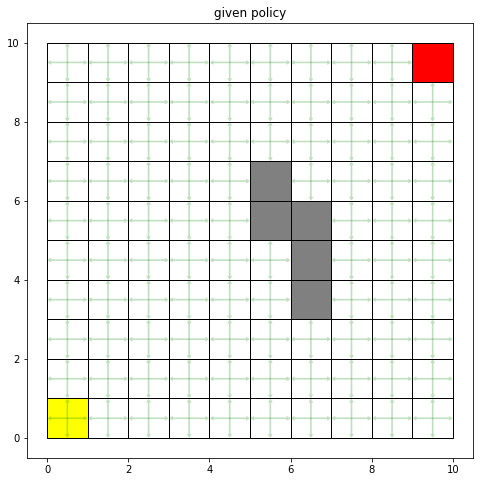

In [3]:
env = GridEnv()
policy = policy_generation(env)
policy_visualize(env, policy)

In [4]:
# transition probability check
# output is [s', reward, probability]
print(env.transition(89,0))
print(env.transition(89,1))
print(env.transition(89,2))
print(env.transition(89,3))

[99 10  1]
[79 -1  1]
[88 -1  1]
[ 89 -10   1]


### 1. Policy Evaluation
It compute the value function for a fixed policy $\pi$.

Following Bellman expectation equation for $V_{\pi}$ is used:

- $V_{k+1}(s) = \sum_a \pi(a|s) \sum_{s'} P(s'|s,a) \left[r + \gamma V_{k}(s')\right]$

In [5]:
def policy_evaluation(env, policy, gamma=0.99, theta=1e-6):
    """
    Policy Evaluation
    """
    # Extract environment information
    n_state = len(env.obs_space)
    
    # initialize
    V = np.zeros(n_state)
    V_history = [V]
    delta_history = []

    while True:
        delta = 0
        # Do not update terminal state and obstacle state
        # Be careful when you store previous value function!!!
        V_nxt = np.zeros(n_state)
        for s in range(len(env.obs_space)):
            if s in env.obstacle_space or s == 99:
                continue
            for a, pi in enumerate(policy[s]):
                s_nxt, reward, prob = env.transition(s, a)
                V_nxt[s] += pi*prob*(reward + gamma*V[s_nxt])
            delta = np.max([delta, np.abs(V_nxt[s] - V[s])])
        V = V_nxt
        
        V_history.append(V)
        delta_history.append(delta)
        if delta < theta:
            break
    
    return V, V_history, delta_history

#### 1.1. Run policy evaluation

In [6]:
start = time.time()
V, V_history, delta_history = policy_evaluation(env, policy, gamma=0.99, theta=1e-6)
print("It took [{:.2f}]s.".format(time.time()-start))
print ("Policy evaluation converged in [{}] loops.".format(len(V_history)))

It took [3.69]s.
Policy evaluation converged in [1237] loops.


#### 1.2. Plot the convergence of policy evaluation

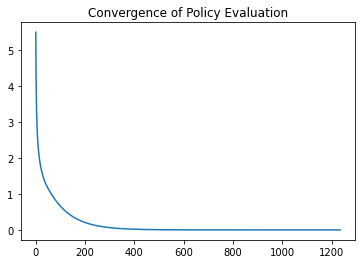

In [7]:
plt.plot(delta_history)
plt.title("Convergence of Policy Evaluation")
plt.show()

#### 1.3. Plot how value function changes over iteration

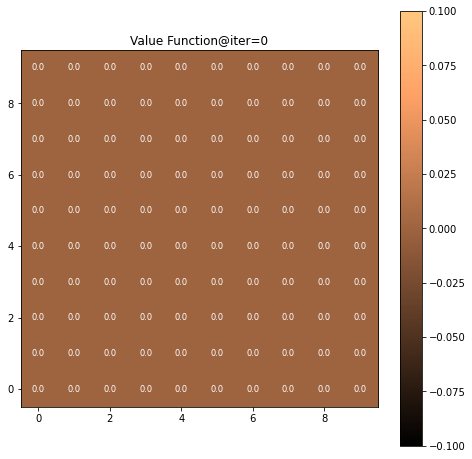

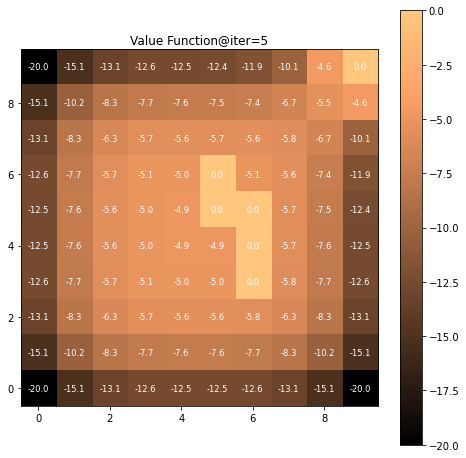

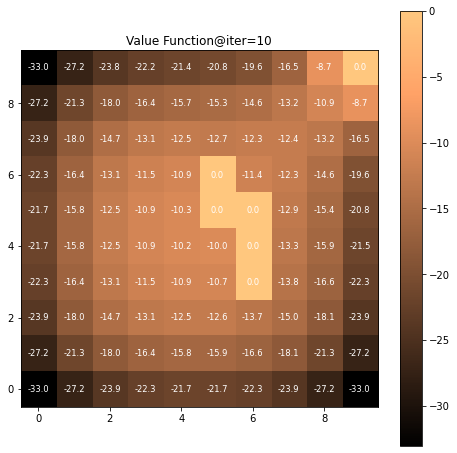

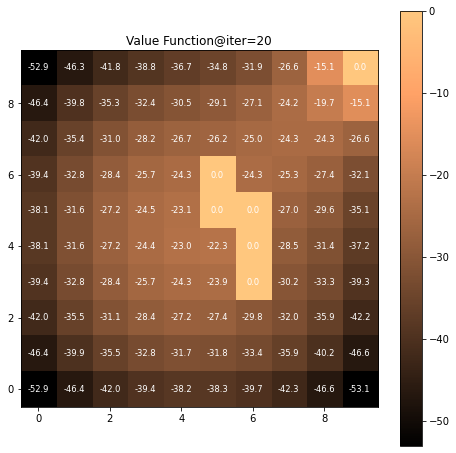

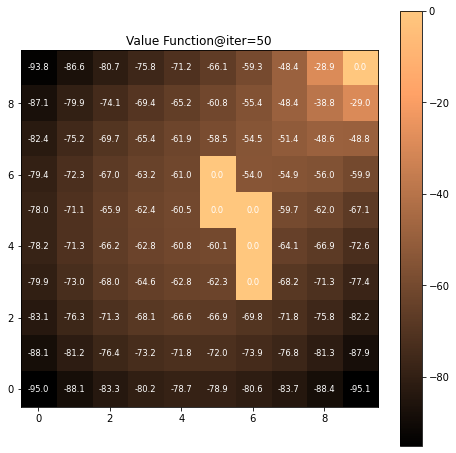

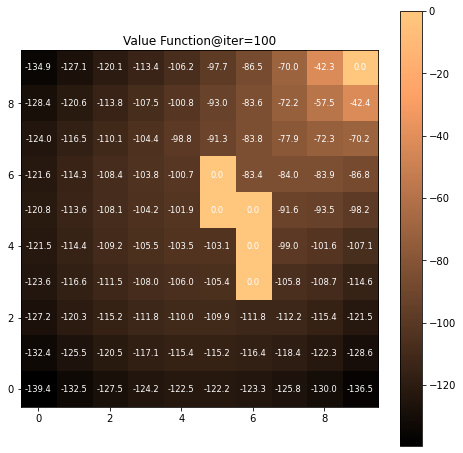

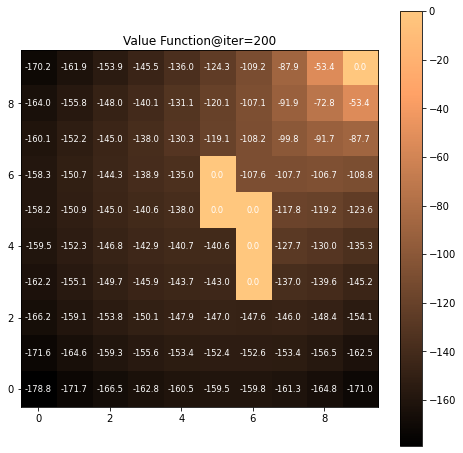

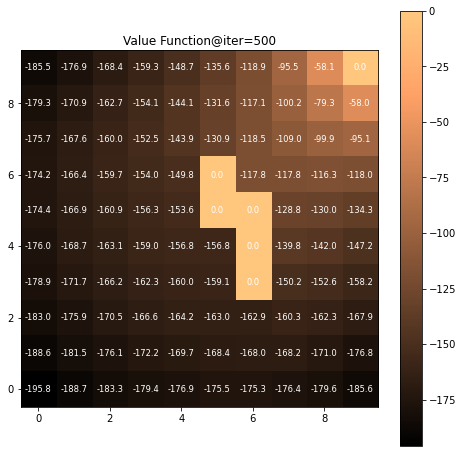

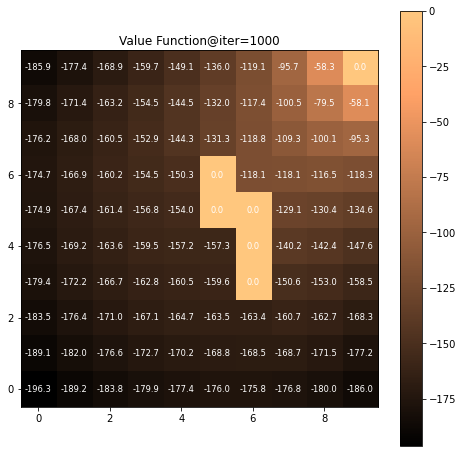

In [8]:
for itr in [0, 5, 10, 20, 50, 100, 200, 500, 1000]:
    V_visual = V_history[itr]
    StateValueFunction_visualize(env, np.reshape(V_visual,(10,10)), title="Value Function@iter={}".format(itr))

### 2. Policy Improvement
In this step, we update the policy distribution using the value function computed by policy evaluation. A new policy distribution is updated greedly as follows:

* $
V_{\pi_k}(s) = \sum_{a}\pi(a|s)\sum_{s'}P(s'|s,a)
\left[
r + \gamma V_{\pi_k}(s')
\right]
$
* $\pi_{k+1}(s) = \arg \max_{a} \sum_{s'}P(s'|s,a)
\left[
r + \gamma V_{\pi_k}(s')
\right]
$

* $Q_{\pi_k}(s,a) = \sum_{s'}P(s'|s,a)
\left[
r + \gamma V_{\pi_k}(s')
\right]
$

* $\pi_{k+1}(s)= \arg \max_a Q_{\pi_k}(s,a)$

In [9]:
def policy_improvement(env, V, gamma=0.99):
    """
    Policy Improvement with state value function
    """

    new_policy = np.zeros([len(env.obs_space), len(env.action_space)])
    
    # for all states except for obstacle and terminal states
    for s in range(len(env.obs_space)):
        if s in env.obstacle_space or s == 99:
            continue
        q_values = []
        # for all actions in this state
        for a in env.action_space:
            s_nxt, reward, prob = env.transition(s, a)
            q_values.append(round(prob*(reward + gamma*V[s_nxt]),6))

        # give any probability (not 0) to argmax action (give 0 others)
        max_actions = np.where(np.array(q_values) == np.max(q_values))[0]
        remain_actions = [a for a in env.action_space if a not in max_actions]    
        for a in max_actions:
            new_policy[s][a] = 1/len(max_actions)
        for a in remain_actions:
            new_policy[s][a] = 0

    return new_policy

#### 2.1. Plot greedy action to given value function

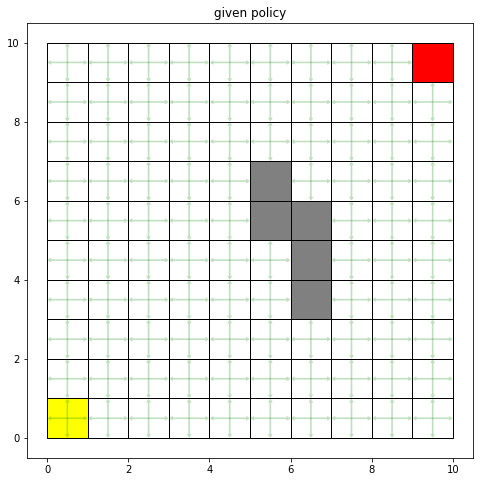

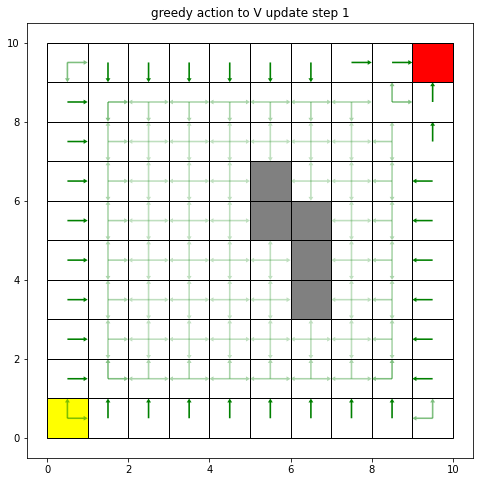

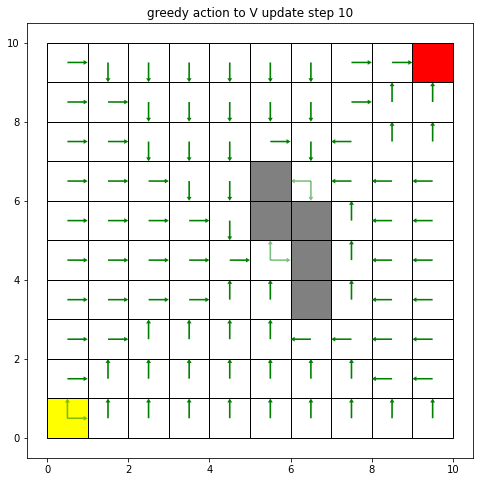

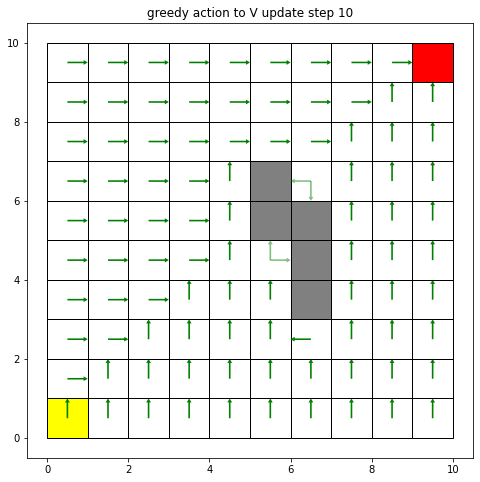

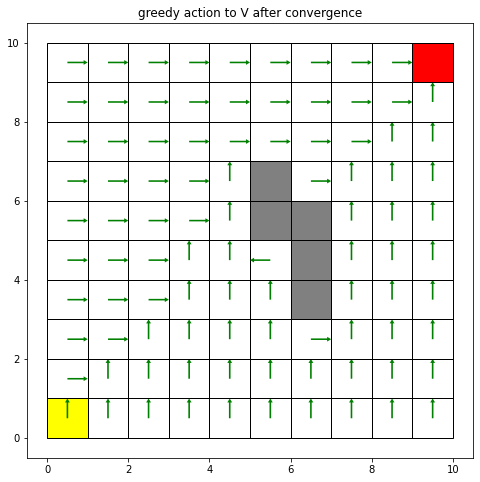

In [10]:
'''
Greedy action to value function means that policy improvement with that value function
'''
policy_visualize(env, policy)
new_policy = policy_improvement(env, V_history[1])
policy_visualize(env, new_policy, "greedy action to V update step 1")
new_policy = policy_improvement(env, V_history[10])
policy_visualize(env, new_policy, "greedy action to V update step 10")
new_policy = policy_improvement(env, V_history[100])
policy_visualize(env, new_policy, "greedy action to V update step 10")
new_policy = policy_improvement(env, V_history[-1])
policy_visualize(env, new_policy, "greedy action to V after convergence")

### 3. Policy Iteration

In [11]:
def policy_iteration(env, gamma=0.99, theta=1e-6):
    # initialize
    policy = policy_generation(env)
    while True:
        # policy evaluation
        start = time.time()
        V, V_history, delta_history = policy_evaluation(env, policy, gamma, theta)
        # policy improvement
        new_policy = policy_improvement(env, V, gamma)
        # termination condition
        if (new_policy == policy).all(): # if the policy does not change
            break
        policy = new_policy
    
    return V, new_policy

#### 3.1. Run policy iteration

In [12]:
start = time.time()
optimal_V, optimal_policy = policy_iteration(env)
print("It took [{:.2f}]s.".format(time.time()-start))

It took [4.03]s.


#### 3.2. Plot environment and the results of policy iteration

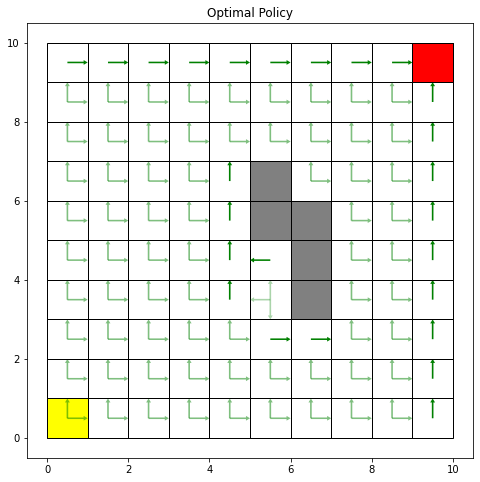

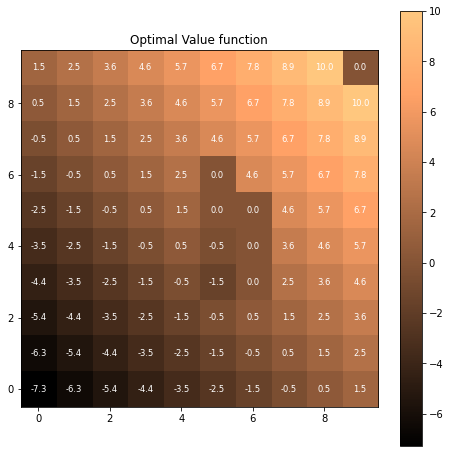

In [13]:
policy_visualize(env, optimal_policy, "Optimal Policy")
StateValueFunction_visualize(env, np.reshape(optimal_V,(10,10)), title="Optimal Value function")

### 4. Test agent with the optimal policy

#### 4.1. Rendering Example

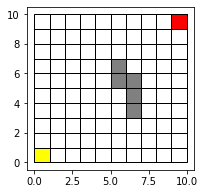

In [14]:
env = GridEnv()
env.reset()
env.render()

#### 4.2. Plot environment and the results of policy iteration

>>> 0 episode
>>> time step [0]


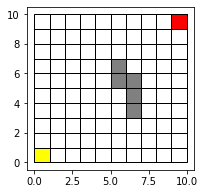

>>> reward: -1
>>> return: -1
>>> time step [1]


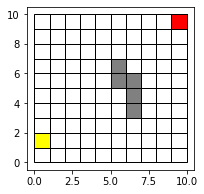

>>> reward: -1
>>> return: -2
>>> time step [2]


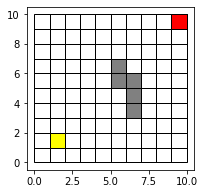

>>> reward: -1
>>> return: -3
>>> time step [3]


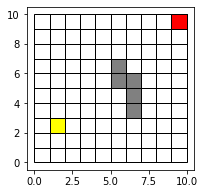

>>> reward: -1
>>> return: -4
>>> time step [4]


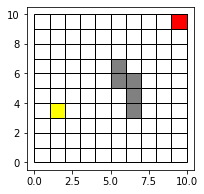

>>> reward: -1
>>> return: -5
>>> time step [5]


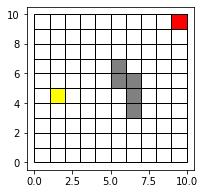

>>> reward: -1
>>> return: -6
>>> time step [6]


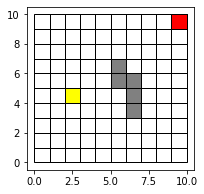

>>> reward: -1
>>> return: -7
>>> time step [7]


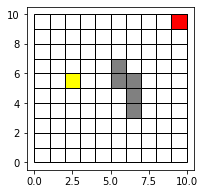

>>> reward: -1
>>> return: -8
>>> time step [8]


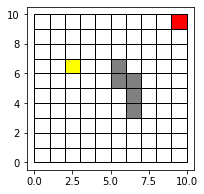

>>> reward: -1
>>> return: -9
>>> time step [9]


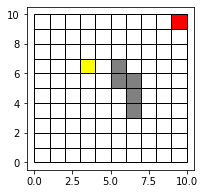

>>> reward: -1
>>> return: -10
>>> time step [10]


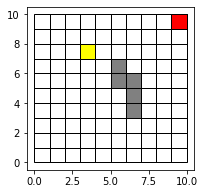

>>> reward: -1
>>> return: -11
>>> time step [11]


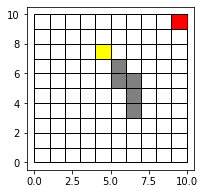

>>> reward: -1
>>> return: -12
>>> time step [12]


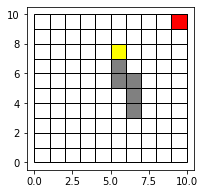

>>> reward: -1
>>> return: -13
>>> time step [13]


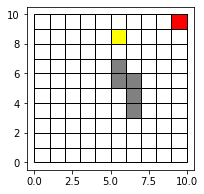

>>> reward: -1
>>> return: -14
>>> time step [14]


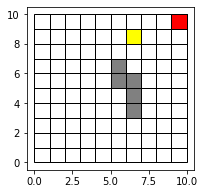

>>> reward: -1
>>> return: -15
>>> time step [15]


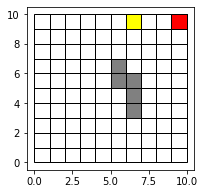

>>> reward: -1
>>> return: -16
>>> time step [16]


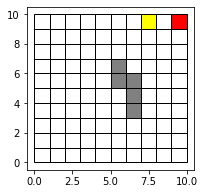

>>> reward: -1
>>> return: -17
>>> time step [17]


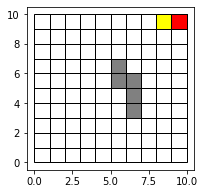

>>> reward: 10
>>> return: -7
>>> time step [18]


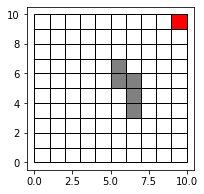

>>> Episode finished after 18 timesteps
>>> Return is -7


In [15]:
env = GridEnv()
ret, gamma = 0, 0.99 # ret means return

for i_episode in range(1):
    obs = env.reset()
    print(">>> {} episode".format(i_episode))
    for t in range(100):
        print(">>> time step [{}]".format(t))
        env.render()
        action = random.choices(env.action_space, weights=optimal_policy[obs])
        reward, obs_nxt, done, info = env.step(action[0])
        obs = obs_nxt
#         ret = reward + gamma*ret
        ret += reward
        print(">>> reward: {}".format(reward))
        print(">>> return: {}".format(ret))
        if done:
            print(">>> time step [{}]".format(t+1))
            env.render()
            print(">>> Episode finished after {} timesteps".format(t+1))
            print(">>> Return is {}".format(ret))
            break

### 5. Value Iteration
* $
V_{k+1}(s) = \max_a \sum_{s'}P(s'|s,a)
\left[
r + \gamma V_k(s')
\right]
$

* $
Q_k(s,a) = \sum_{s'}P(s'|s,a)
\left[
r + \gamma V_k(s')
\right]
$
and
$
V_{k+1}(s) = \max_{a'} Q_k(s,a')
$

In [16]:
def value_iteration(env, gamma=0.99, theta=1e-6):
    """
    Value Iteration
    """
    # Extract environment information
    n_state = len(env.obs_space)
    
    # initialize
    V = np.zeros(n_state)
    V_history = [V]
    delta_history = []

    while True:
        delta = 0
        # Do not update terminal state and obstacle state
        # Be careful when you store previous value function!!!
        V_nxt = np.zeros(n_state)
        for s in range(len(env.obs_space)):
            if s in env.obstacle_space or s == 99:
                continue

            q_values = []
            # for all actions in this state
            for a in env.action_space:
                s_nxt, reward, prob = env.transition(s, a)
                q_values.append(round(prob*(reward + gamma*V[s_nxt]),6))

            V_nxt[s] = np.max(q_values)
            delta = np.max([delta, np.abs(V_nxt[s] - V[s])])

        V = V_nxt
        V_history.append(V)
        delta_history.append(delta)
        if delta < theta:
            break

    optimal_policy = policy_improvement(env, V, gamma)
    
    return V, V_history, delta_history, optimal_policy

#### 5.1. Run value iteration

In [17]:
start = time.time()
optimal_V, V_history, delta_history, optimal_policy = value_iteration(env, gamma=0.99, theta=1e-6)
print("It took [{:.2f}]s.".format(time.time()-start))
print ("Value Iteraction converged in [{}] loops.".format(len(V_history)))

It took [0.13]s.
Value Iteraction converged in [20] loops.


#### 5.2. Plot the convergence of value iteration

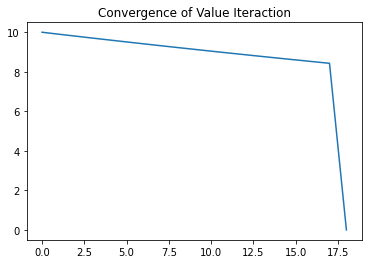

In [18]:
plt.plot(delta_history)
plt.title("Convergence of Value Iteraction")
plt.show()

#### 5.3. Visualize the results of value iteration

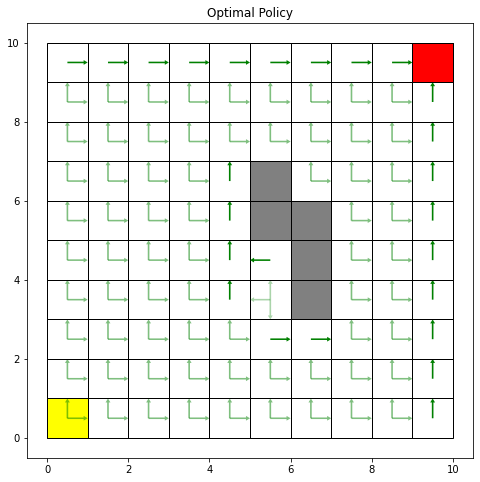

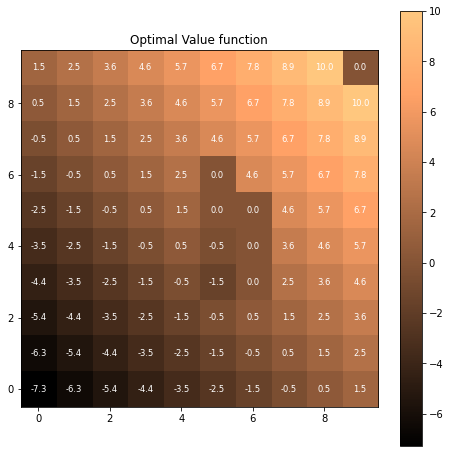

In [19]:
policy_visualize(env, optimal_policy, "Optimal Policy")
StateValueFunction_visualize(env, np.reshape(optimal_V,(10,10)), title="Optimal Value function")